In [1]:
import pandas as pd 
import requests
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
import pylab
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pylab.rcParams['figure.figsize'] = (14,10)
%matplotlib inline
import plotly.express as px
from plotly.io import write_html
from datetime import datetime


In [2]:
url = "https://min-api.cryptocompare.com/data/v2/histoday"


In [3]:
key = os.getenv("cryptocompare_key")

In [4]:
payload = {
    "api_key": key,
    "fsym": "BTC",
    "tsym": "USD",
    "limit": 730
}

In [9]:
result = requests.get(url, params = payload).json()

In [10]:
coin_df = pd.DataFrame(result['Data']['Data'])

In [11]:
coin_df

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
0,1516060800,13648.84,10032.69,13634.60,325702.79,3.842652e+09,11282.49,direct,
1,1516147200,11736.30,9205.38,11282.49,348631.94,3.666978e+09,11162.70,direct,
2,1516233600,12018.43,10642.33,11162.70,204918.02,2.357252e+09,11175.52,direct,
3,1516320000,11780.49,10867.18,11175.52,110885.87,1.264876e+09,11521.76,direct,
4,1516406400,13031.04,11502.11,11521.82,119084.84,1.492722e+09,12783.94,direct,
...,...,...,...,...,...,...,...,...,...
726,1578787200,8185.14,7968.40,8024.58,17525.61,1.421976e+08,8181.49,direct,
727,1578873600,8200.40,8057.37,8181.49,22746.00,1.844375e+08,8106.56,direct,
728,1578960000,8874.07,8106.40,8106.56,89444.78,7.680985e+08,8820.95,direct,
729,1579046400,8890.04,8559.93,8820.95,50394.79,4.411869e+08,8813.21,direct,


In [17]:
coin_df['time'] = pd.to_datetime(coin_df['time'], unit = 's', format = "%Y-%m-%d")

In [19]:
coin_df['time'] = coin_df['time'].dt.strftime("%Y-%m-%d")

In [20]:
coin_df['time'][0]

'2018-01-16'

In [21]:
coin_df = coin_df.drop(columns = ['volumefrom', 'volumeto', 'conversionType', 'conversionSymbol'])

In [22]:
coin_df = coin_df.rename(columns = {'time': 'Date'})

In [23]:
coin_df = coin_df.set_index('Date')

In [24]:
coin_df.head()


,high,low,open,close
Date,,,,
2018-01-16,13648.84,10032.69,13634.60,11282.49
2018-01-17,11736.30,9205.38,11282.49,11162.70
2018-01-18,12018.43,10642.33,11162.70,11175.52
2018-01-19,11780.49,10867.18,11175.52,11521.76
2018-01-20,13031.04,11502.11,11521.82,12783.94


In [25]:
close_df = pd.DataFrame(coin_df['close'])

In [26]:
close_df.head()

,close
Date,
2018-01-16,11282.49
2018-01-17,11162.70
2018-01-18,11175.52
2018-01-19,11521.76
2018-01-20,12783.94


In [ ]:
stationary_test = adfuller(close_df['close'])
print(stationary_test[1])

In [ ]:
close_df.plot()
plt.show()

In [27]:
transform_data, lmda = boxcox(close_df)

In [28]:
print(lmda)

[0.8568422]


In [29]:
transformed_df = close_df.copy()

In [30]:
transformed_data = transform_data.flatten().tolist()

In [31]:
transformed_df['close'] = transformed_data

In [32]:
transformed_df.head()

,close
Date,
2018-01-16,3461.181129
2018-01-17,3429.658787
2018-01-18,3433.034633
2018-01-19,3524.001486
2018-01-20,3852.398911


In [33]:
transformed_df.tail()

,close
Date,
2020-01-12,2627.763322
2020-01-13,2607.119559
2020-01-14,2802.866596
2020-01-15,2800.758274
2020-01-16,2770.837213


In [ ]:
seasonal_decompose(transformed_df).plot()
plt.show()

In [ ]:
plot_acf(transformed_df)
plt.show()

In [ ]:
plot_pacf(transformed_df)
plt.show()

In [34]:
model = SARIMAX(transformed_df, order = ((0,0,0,0,0,0,0,0,1,0,0,0,0,1),1,(1,0,1,1,1)))


C:\Users\willi\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [35]:
model_fit = model.fit(disp = True)

In [36]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   Statespace Model Results                                  
=============================================================================================
Dep. Variable:                                 close   No. Observations:                  731
Model:             SARIMAX((9, 14), 1, (1, 3, 4, 5))   Log Likelihood               -4300.002
Date:                               Thu, 16 Jan 2020   AIC                           8614.004
Time:                                       15:00:17   BIC                           8646.156
Sample:                                   01-16-2018   HQIC                          8626.409
                                        - 01-16-2020                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L9         -0.0761      0.030     -2.547      0.011      -0.135      -0.018
ar.L14         0.0310      0.028      1.118      0.263      -0.023       0.085
ma.L1         -0.0592      0.023     -2.586      0.010      -0.104      -0.014
ma.L3          0.0608      0.027      2.265      0.024       0.008       0.113
ma.L4         -0.0178      0.027     -0.650      0.516      -0.071       0.036
ma.L5          0.0054      0.028      0.195      0.845      -0.049       0.059
sigma2      7653.8664    239.451     31.964      0.000    7184.550    8123.182
===================================================================================
Ljung-Box (Q):                       34.87   Jarque-Bera (JB):               460.41
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.23
Prob(H) (two-sided):                  0.83   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\willi\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



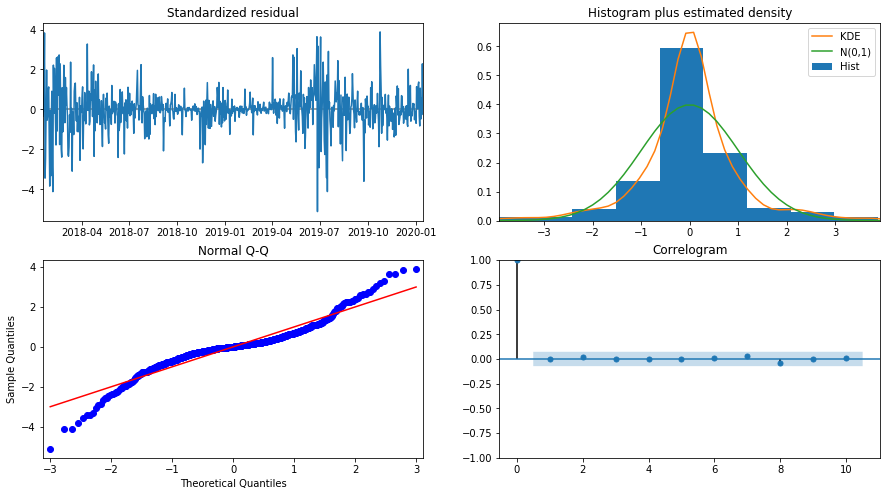

In [37]:
model_fit.plot_diagnostics(figsize=(15,8))
plt.show()

In [38]:
conf_int = model_fit.get_forecast(5)

In [39]:
confidence_intervals = conf_int.conf_int()

In [40]:
confidence_intervals = inv_boxcox(confidence_intervals, lmda)

In [41]:
confidence_intervals

,lower close,upper close
2020-01-17,8148.946152,9406.959027
2020-01-18,7924.924415,9652.259822
2020-01-19,7715.813490,9808.596386
2020-01-20,7570.609437,10013.941213
2020-01-21,7426.214354,10164.794718


In [42]:
predictions = model_fit.predict(start= 731, end = 735 )

In [43]:
predictions

2020-01-17    2790.270744
2020-01-18    2792.391890
2020-01-19    2784.412444
2020-01-20    2791.730320
2020-01-21    2791.755839
Freq: D, dtype: float64

In [44]:
predicted_close = inv_boxcox(predictions, lmda)

In [45]:
predicted_close

2020-01-17    8774.723005
2020-01-18    8782.505213
2020-01-19    8753.234809
2020-01-20    8780.077893
2020-01-21    8780.171522
Freq: D, dtype: float64

In [46]:
final_df = confidence_intervals.copy()

In [47]:
final_df['predicted_close'] = predicted_close

In [48]:
final_df = final_df.round(2)

In [49]:
final_df = final_df.reset_index()

In [53]:
final_df

,index,lower close,upper close,predicted_close
0,2020-01-17,8148.95,9406.96,8774.72
1,2020-01-18,7924.92,9652.26,8782.51
2,2020-01-19,7715.81,9808.60,8753.23
3,2020-01-20,7570.61,10013.94,8780.08
4,2020-01-21,7426.21,10164.79,8780.17


In [54]:
final_df['index'] = final_df['index'].dt.strftime("%Y-%m-%d")

In [55]:
final_df['index'][0]

'2020-01-17'

In [56]:
final_df['index'][0]

'2020-01-17'

In [ ]:
#final_df.index = final_df.index.dt.strftime("%Y-%m-%d")

In [57]:
final_df['index'][0]

'2020-01-17'

In [68]:
dates = final_df['index']

In [69]:
dates

0    2020-01-17
1    2020-01-18
2    2020-01-19
3    2020-01-20
4    2020-01-21
Name: index, dtype: object

In [70]:
final_df = final_df.drop(columns = 'index')

In [71]:
final_df['date'] = dates

In [73]:
final_df['date'][0]

'2020-01-17'

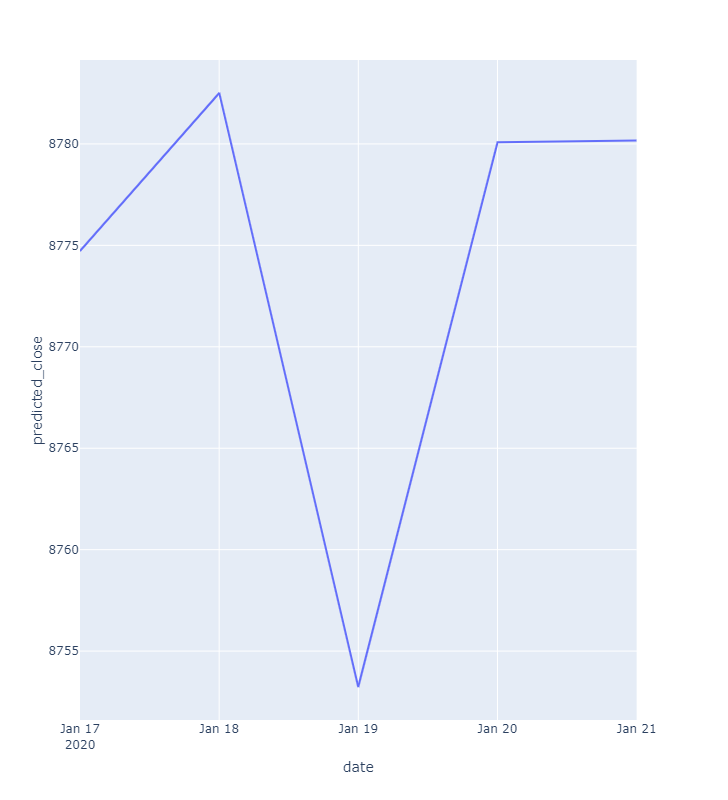

In [77]:
fig = px.line(final_df, x ='date', y = 'predicted_close')
fig.update_xaxes(nticks = 5)
fig.update_layout(autosize = True, height = 800, width = 950)
fig.update_yaxes(automargin=True)